# Import Required Libraries

In [1]:
import sys
import os
os.chdir("..")
os.chdir("./src")
# sys.path.append("./src")

In [2]:
from IPython import display
from IPython.display import clear_output
import pylab as pl
import numpy as np
import matplotlib.pyplot as plt
from numba import njit, jit
from time import time
# from helpers import *
from LDMIBSS import *
# np.random.seed(13)
%load_ext autoreload
%autoreload 2

# Source Generation and Mixing Scenario

In [3]:
dim = 3
N = 500000
NumberofSources = dim
NumberofMixtures = 6

signed_dims = np.array([0,1])
nn_dims = np.array([2])
sparse_dims_list = [np.array([0,1]),np.array([1,2])]
(A,b), V = generate_practical_polytope(dim, signed_dims, nn_dims, sparse_dims_list)
S = generate_uniform_points_in_polytope(V, N)

Text(0.5, 0.98, 'Scatter Plot of Source Components')

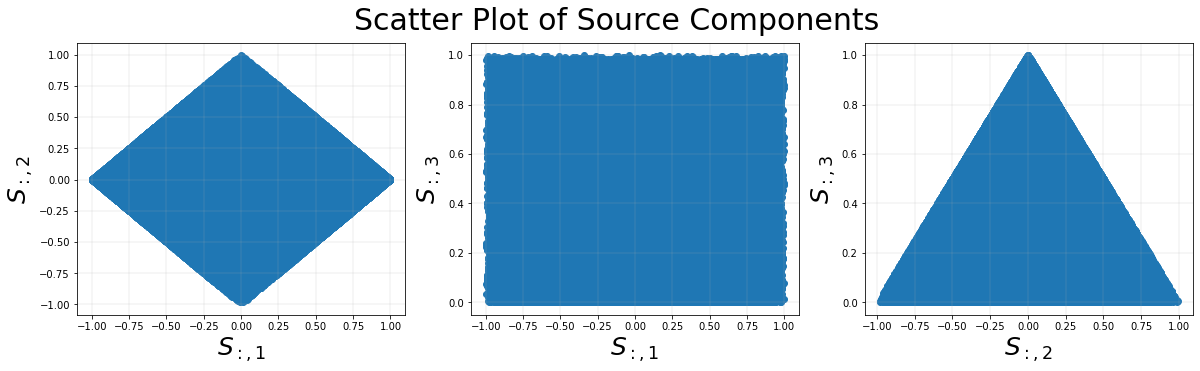

In [4]:
plt.figure(figsize = (20,5))
plt.subplot(1,3,1)
plt.scatter(S[0,:], S[1,:])
plt.xlabel("$S_{:,1}$", fontsize = 25)
plt.ylabel("$S_{:,2}$", fontsize = 25)
plt.grid(linewidth=.2)
plt.subplot(1,3,2)
plt.scatter(S[0,:], S[2,:])
plt.xlabel("$S_{:,1}$", fontsize = 25)
plt.ylabel("$S_{:,3}$", fontsize = 25)
plt.grid(linewidth=.2)
plt.subplot(1,3,3)
plt.scatter(S[1,:], S[2,:])
plt.xlabel("$S_{:,2}$", fontsize = 25)
plt.ylabel("$S_{:,3}$", fontsize = 25)
plt.grid(linewidth=.2)

plt.suptitle("Scatter Plot of Source Components", fontsize = 30)
# plt.savefig('Pex_source_components.pdf', format='pdf', dpi = 1200)

In [5]:
# Generate Mxr random mixing from i.i.d N(0,1)
A = np.random.randn(NumberofMixtures,NumberofSources)
X = np.dot(A,S)

SNR = 30 # dB
NoiseAmp = (10 ** (-SNR/20))# * np.sqrt(NumberofSources)
NoisePart = NoiseAmp * np.random.randn(X.shape[0], X.shape[1])
X = X  + NoisePart
SNRinp = 10 * np.log10(np.sum(np.var(X, axis = 1)) / np.sum(np.var(NoisePart, axis = 1)))
print("The following is the mixture matrix A")
display_matrix(A)
print("Input SNR is : {}".format(SNRinp))

The following is the mixture matrix A


<IPython.core.display.Math object>

Input SNR is : 24.682331196324828


# Visualize Generated Sources and Mixtures

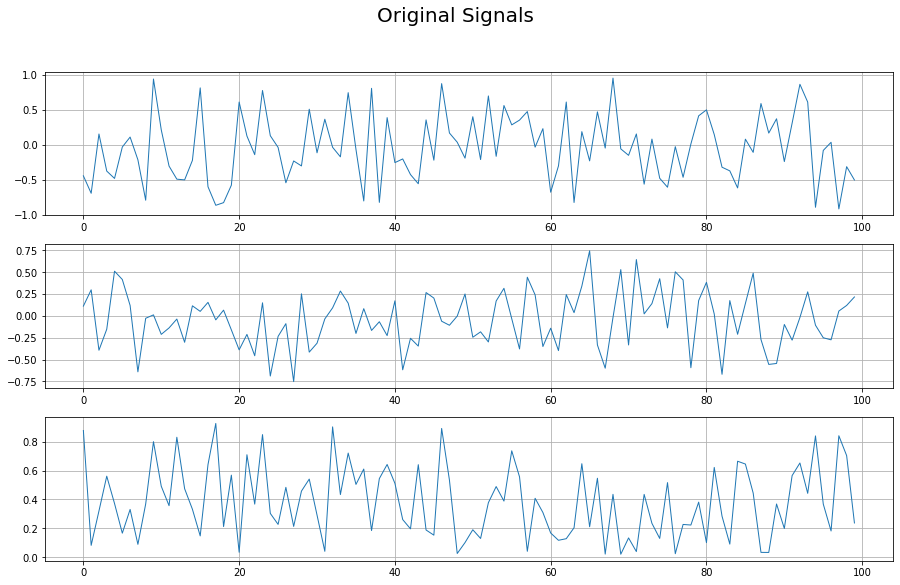

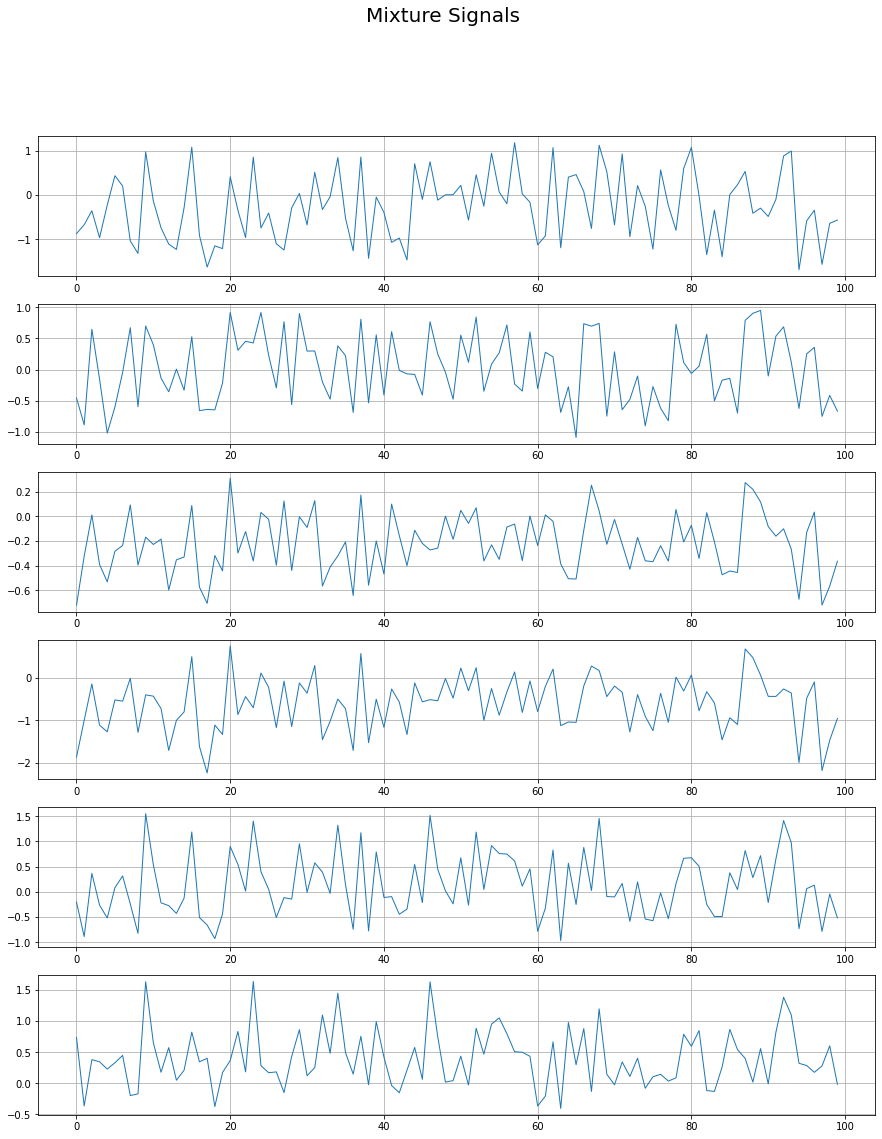

In [6]:
subplot_1D_signals(S.T[0:100], title = 'Original Signals', figsize = (15.2,9), colorcode = None)
subplot_1D_signals(X.T[0:100], title = 'Mixture Signals', figsize = (15,18), colorcode = None)

# Algorithm Hyperparameter Selection and Weight Initialization

In [7]:
lambday = 1 - 1e-1/10
lambdae = 1 - 1e-1/10
s_dim = S.shape[0]
x_dim = X.shape[0]

# Inverse output covariance
By = 5 * np.eye(s_dim)
# Inverse error covariance
Be = 1000 * np.eye(s_dim)

debug_iteration_point = 10000
model = OnlineLDMIBSS(s_dim = s_dim, x_dim = x_dim, muW = 50*1e-3, lambday = lambday,
                      lambdae = lambdae, By = By, Be = Be, neural_OUTPUT_COMP_TOL = 1e-6,
                      set_ground_truth = True, S = S, A = A)

# Run CorInfoMax Algorithm on Mixture Signals

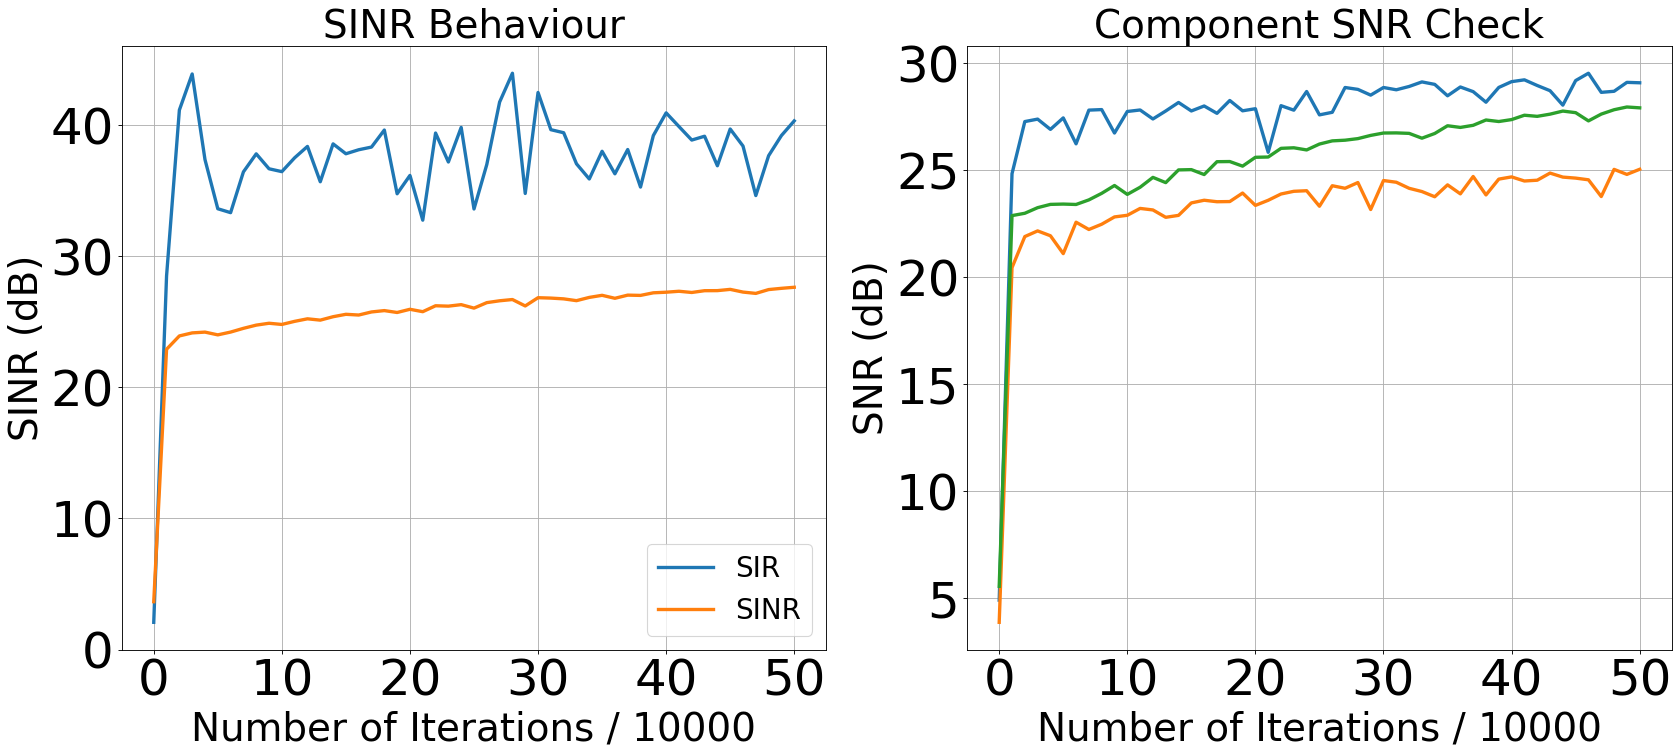

100%|██████████| 500000/500000 [11:56<00:00, 698.00it/s]


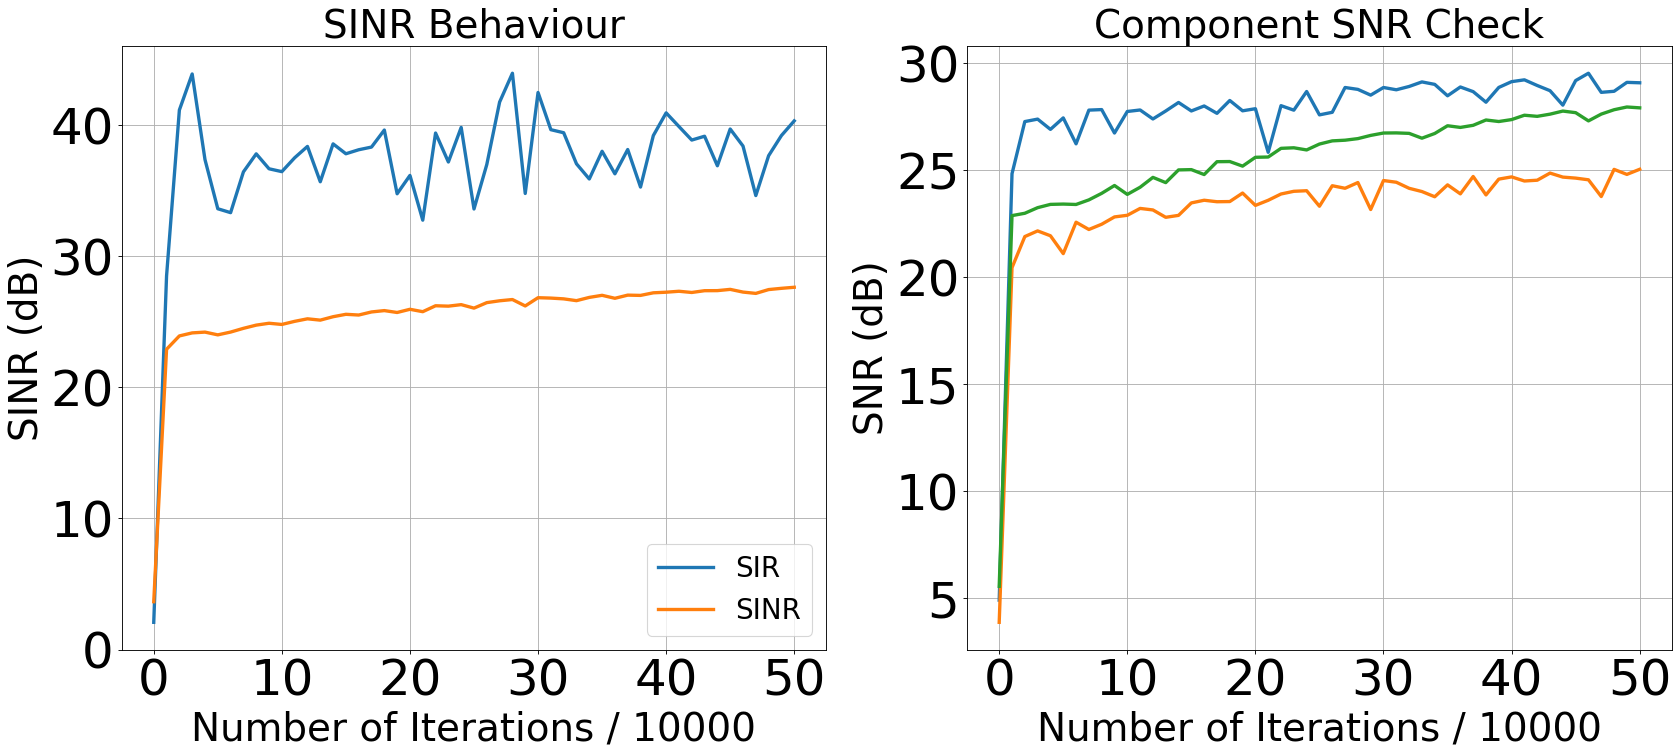

In [8]:
model.fit_batch_general_polytope(X = X, signed_dims = signed_dims, nn_dims = nn_dims,
                                 sparse_dims_list = sparse_dims_list,n_epochs = 1, neural_dynamic_iterations = 500,
                                 plot_in_jupyter = True, neural_lr_start = 0.1, neural_lr_stop = 1e-10,
                                 debug_iteration_point = debug_iteration_point, 
                                 shuffle = True)

# Visualize SINR Convergence 

Final SINR: 27.619528899888873


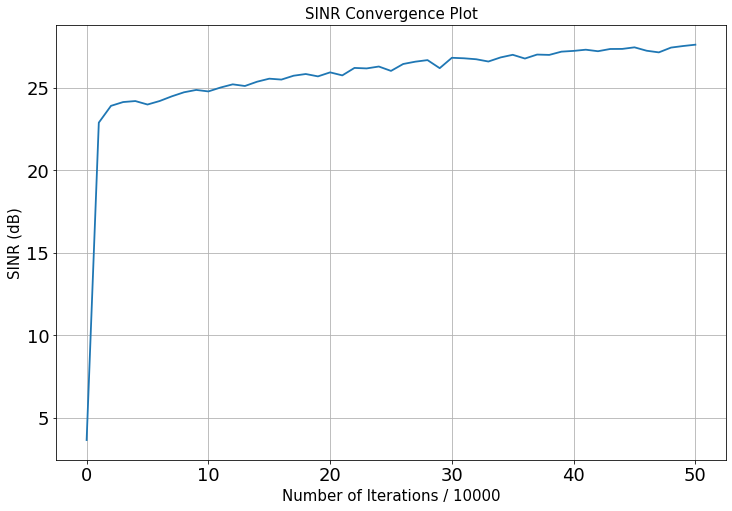

In [9]:
mpl.rcParams['xtick.labelsize'] = 18
mpl.rcParams['ytick.labelsize'] = 18
plot_convergence_plot(model.SINR_list, xlabel = 'Number of Iterations / {}'.format(debug_iteration_point),
                     ylabel = 'SINR (dB)', title = 'SINR Convergence Plot', colorcode = None, linewidth = 1.8)

print('Final SINR: {}'.format(np.array(model.SINR_list[-1])))

# Calculate Resulting Component SNRs and Overall SINR

In [10]:
Wf = model.compute_overall_mapping(return_mapping = True)
Y_ = Wf @ X
Y_ = model.signed_and_permutation_corrected_sources(S.T,Y_.T)
coef_ = (Y_ * S.T).sum(axis = 0) / (Y_ * Y_).sum(axis = 0)
Y_ = coef_ * Y_

print("Component SNR Values : {}\n".format(snr(S.T, Y_)))

SINR = 10*np.log10(model.CalculateSINR(Y_.T, S)[0])

print("Overall SINR : {}".format(SINR))

Component SNR Values : [29.07812196 25.03792817 27.90727514]

Overall SINR : 27.619528899888873


# Vizualize Extracted Signals Compared to Original Sources

In [11]:
Wf = model.compute_overall_mapping(return_mapping = True)
Y = Wf @ X
Y_ = model.signed_and_permutation_corrected_sources(S.T,Y.T).T
Y_.shape, X.shape, S.shape

((3, 500000), (6, 500000), (3, 500000))

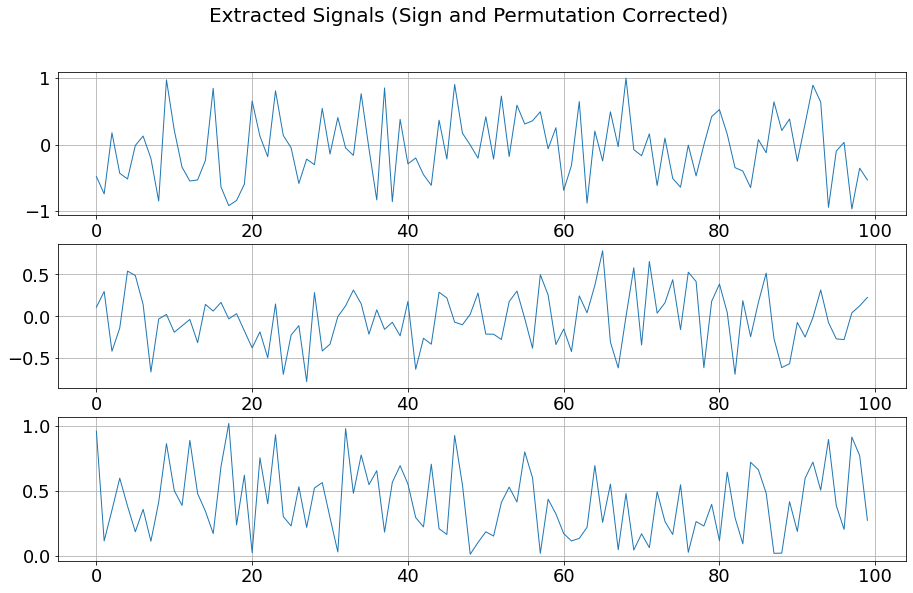

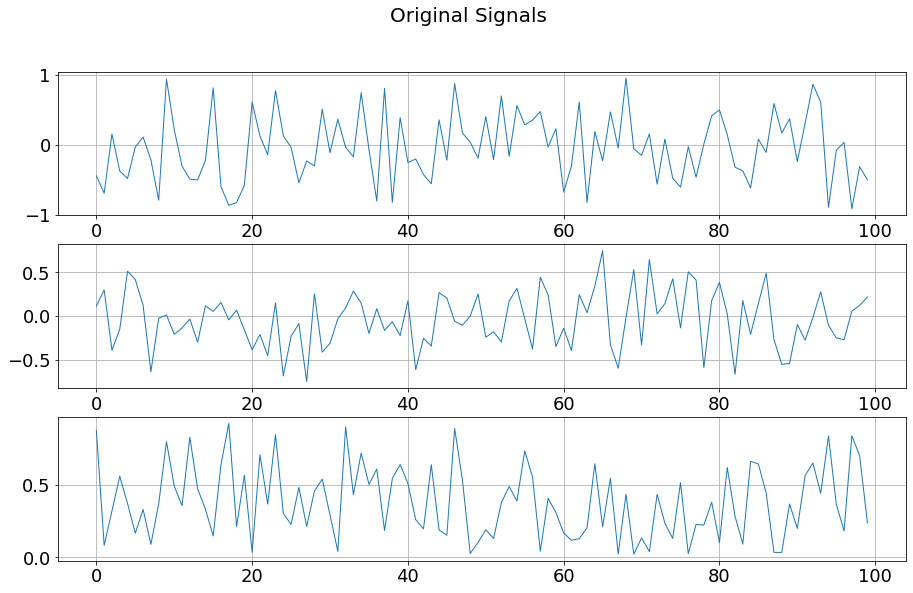

In [12]:
subplot_1D_signals(X = Y_.T[0:100], title = 'Extracted Signals (Sign and Permutation Corrected)' ,figsize = (15.2,9), colorcode = None)
subplot_1D_signals(X = S.T[0:100], title = 'Original Signals' ,figsize = (15.2,9), colorcode = None)